## Step 1: Install required python packages for the below examples

`pip install mlxtend scikit-learn numpy scipy matplotlib pandas`

## Step 2: Download the MNIST dataset for training Lenet

The MNIST dataset was constructed from two datasets of the US National Institute of Standards and Technology (NIST). The training set consists of handwritten digits from 250 different people, 50 percent high school students, and 50 percent employees from the Census Bureau. Note that the test set contains handwritten digits from different people following the same split.

Lenet is a simple convolutional neural network, proposed by Yann LeCun in 1998. It has 2 convolutions/pooling and fully connected layer. Similar to Caffe, the network has been modified to add dropout. For more detail, please see http://yann.lecun.com/exdb/lenet/

In [1]:
from mlxtend.data import mnist_data
import numpy as np
from sklearn.utils import shuffle
X, y = mnist_data()
X, y = shuffle(X, y)
num_classes = np.unique(y).shape[0]
img_shape = (1, 28, 28)

## Step 3: Split the data into training and test

In [2]:
n_samples = len(X)
X_train = X[:.9 * n_samples]
y_train = y[:.9 * n_samples]
X_test = X[.9 * n_samples:]
y_test = y[.9 * n_samples:]

/home/biuser/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/home/biuser/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/home/biuser/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/biuser/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## Step 4: Download the Caffe specification of Lenet network

See https://github.com/niketanpansare/model_zoo/tree/master/caffe/vision/lenet/mnist for more details.

In [3]:
import urllib
urllib.urlretrieve('https://raw.githubusercontent.com/niketanpansare/model_zoo/master/caffe/vision/lenet/mnist/lenet.proto', 'lenet.proto')
urllib.urlretrieve('https://raw.githubusercontent.com/niketanpansare/model_zoo/master/caffe/vision/lenet/mnist/lenet_solver.proto', 'lenet_solver.proto')

('lenet_solver.proto', <httplib.HTTPMessage instance at 0x7f5cb41e45a8>)

## Step 5: Train Lenet On MNIST using scikit-learn like API

  1. Create a neural network using the Caffe specification (by downloading it from model zoo (see step 4) or using either [drag-drop UI](http://yanglei.me/gen_proto/),or [Caffe's Python API](https://github.com/BVLC/caffe/blob/master/python/caffe/test/test_net_spec.py#L7))

In [5]:
from systemml.mllearn import Barista
from pyspark.sql import SQLContext
sql_ctx = SQLContext(sc)
max_iter = 500
lenet = Barista(sql_ctx, num_classes, 'lenet_solver.proto', 'lenet.proto', img_shape, max_iter)
print('Lenet score: %f' % lenet.fit(X_train, y_train).score(X_test, y_test))

Lenet score: 0.986000


## Step 6: (Optional) Visualize the training/validation loss and accuracy

/home/biuser/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


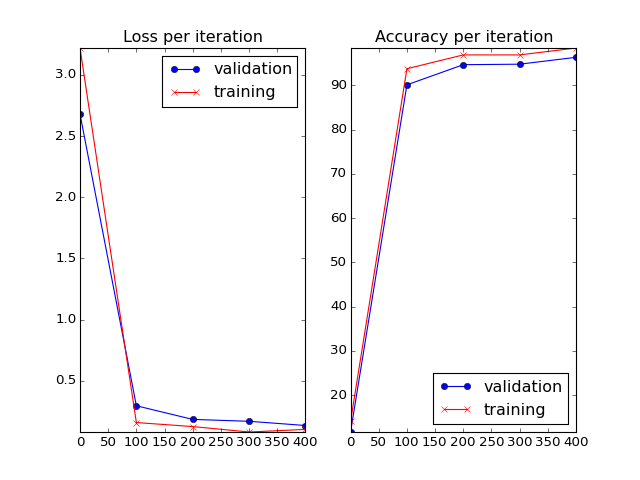

/home/biuser/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)


barista

In [4]:
%matplotlib notebook

from systemml.mllearn import Barista
from pyspark.sql import SQLContext
sql_ctx = SQLContext(sc)
max_iter = 500
lenet = Barista(sql_ctx, num_classes, 'lenet_solver.proto', 'lenet.proto', img_shape, max_iter).visualize()
lenet.fit(X_train, y_train)

## Step 7: (Optional) Summarize the learned weights over time

It is useful to track the statistics over weights, biases, gradients and the output activations over time. The `visualize()` method of the `Barista` class allows you to do that. 

```
visualize(layerName=None, varType='weight', aggFn='mean')
varType: should be either 'weight', 'bias', 'dweight', 'dbias', 'output' or 'doutput'
aggFn: should be either 'sum', 'mean', 'var' or 'sd'
```

<IPython.core.display.Javascript object>


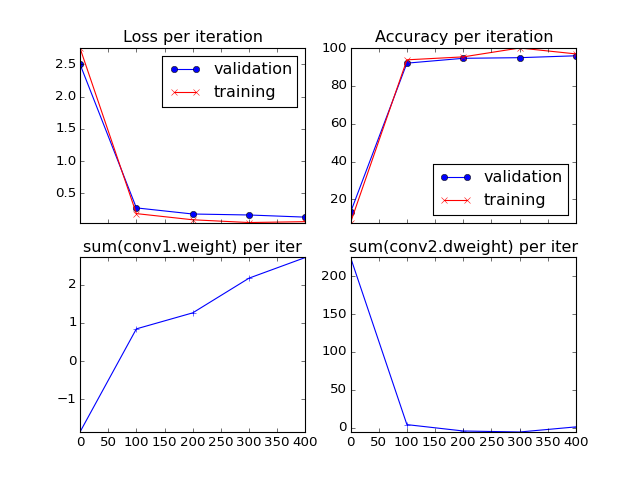

barista

In [5]:
%matplotlib notebook

from systemml.mllearn import Barista
from pyspark.sql import SQLContext
sql_ctx = SQLContext(sc)
max_iter = 500
lenet = Barista(sql_ctx, num_classes, 'lenet_solver.proto', 'lenet.proto', img_shape, max_iter)
lenet.visualize('conv1', 'weight', 'sum')
lenet.visualize('conv2', 'dweight', 'sum')
lenet.fit(X_train, y_train)

## Step 8: Use a pretrained VGG 19 layer model to predict an image

The below example describes how one can load a pretrained VGG 19 layer model and use it to predict an image.

In [ ]:
from systemml.mllearn import Barista
from pyspark.sql import SQLContext
import numpy as np
import urllib, os, scipy.ndimage
from PIL import Image

# ImageNet specific parameters
img_shape = (3, 224, 224)
num_classes = 1000

# Utility method that downloads a jpg image, resizes it to 224 and return as numpy array in N X CHW format
def downloadAsNumPyArray(url):
    outFile = 'test.jpg'
    urllib.urlretrieve(url, outFile + '.tmp')
    Image.open(outFile + '.tmp').resize( (224,224), Image.LANCZOS).save(outFile)
    os.remove(outFile + '.tmp')
    t = np.einsum('ijk->kij', scipy.ndimage.imread(outFile))
    return t.reshape(1, t.size)


input_image = downloadAsNumPyArray('https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/MountainLion.jpg/312px-MountainLion.jpg')
assert input_image.shape == (1, img_shape[0]*img_shape[1]*img_shape[2])

vgg_dir = '< path to model_zoo/caffe/vision/vgg/ilsvrc12 >'
sql_ctx = SQLContext(sc)
vgg = Barista(sql_ctx, num_classes, os.path.join(vgg_dir, 'VGG_ILSVRC_19_layers_solver.proto'), os.path.join(vgg_dir, 'VGG_ILSVRC_19_layers_network.proto'), img_shape)
vgg.load(os.path.join(vgg_dir, 'VGG_ILSVRC_19_pretrained_weights'))
vgg.predict(input_image)